In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from tensorflow import keras

In [2]:
from tensorflow.keras.preprocessing import image

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [5]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

# Import the metadata
### Decoder Ring for Labels: 1='positive', 0='negative', -1='uncertain' and NaN='no mention of condition in radiology report'

In [6]:
train_info = pd.read_csv('CheXpert-v1.0-small/train.csv')
print(train_info.shape)

# Add in the tiny pre-segregated validation set (just 234 rows) and we'll split later ourselves

train_info = pd.concat([train_info, pd.read_csv('CheXpert-v1.0-small/valid.csv')], axis=0)

print(train_info.shape)
train_info.head()

(223414, 19)
(223648, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### Let's drop the Lateral views:

In [7]:
cols = ['Path', 'Sex', 'Age', 'AP/PA', 'Atelectasis', 'Cardiomegaly', 'Edema', 'Pleural Effusion']

train_info = train_info[(train_info['Frontal/Lateral'] == 'Frontal')][cols]

print(train_info.shape)
train_info.head()

(191229, 8)


,Path,Sex,Age,AP/PA,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,AP,NaN,NaN,NaN,NaN
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,AP,-1.0,-1.0,-1.0,-1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,AP,NaN,NaN,NaN,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,AP,NaN,NaN,1.0,NaN
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,PA,NaN,NaN,NaN,0.0


### 'AP' means X-ray taken from the front; let's just keep these and drop the 'PA' X-rays (shot from behind the patient)

In [8]:
print('AP: {}'.format(train_info[train_info['AP/PA'] == 'AP'].shape))
print('PA: {}'.format(train_info[train_info['AP/PA'] == 'PA'].shape))

train_info = train_info[train_info['AP/PA'] == 'AP'].drop(columns='AP/PA')

print(train_info.shape)
train_info.head()

AP: (161759, 8)
PA: (29453, 8)
(161759, 7)


,Path,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,NaN,NaN,NaN,NaN
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,-1.0,-1.0,-1.0,-1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,NaN,NaN,NaN,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,NaN,NaN,1.0,NaN
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,NaN,NaN,NaN,NaN


### NaN means "no mention" on report, so we'll assume this maps to 0 ("negative"); otherwise, the report would have mentioned the condition

In [9]:
train_info['Atelectasis'] = train_info['Atelectasis'].apply(lambda x: 0 if np.isnan(x) else x).astype(int)

train_info['Cardiomegaly'] = train_info['Cardiomegaly'].apply(lambda x: 0 if np.isnan(x) else x).astype(int)

train_info['Edema'] = train_info['Edema'].apply(lambda x: 0 if np.isnan(x) else x).astype(int)

train_info['Pleural Effusion'] = train_info['Pleural Effusion'].apply(lambda x: 0 if np.isnan(x) else x).astype(int)

train_info.head()

,Path,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,0,0,0,0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,-1,-1,-1,-1
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,0,0,0,0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,0,0,1,0
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,0,0,0,0


### -1.0 target labels are 'uncertain', but to be "safe," we want to flag these as potential positives, so remap them to 1.0 ('positive'):

In [10]:
train_info['Atelectasis'] = train_info['Atelectasis'].apply(lambda x: 1 if x == -1 else x).astype(int)

train_info['Cardiomegaly'] = train_info['Cardiomegaly'].apply(lambda x: 1 if x == -1 else x).astype(int)

train_info['Edema'] = train_info['Edema'].apply(lambda x: 1 if x == -1 else x).astype(int)

train_info['Pleural Effusion'] = train_info['Pleural Effusion'].apply(lambda x: 1 if x == -1 else x).astype(int)

train_info.head()

,Path,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,0,0,0,0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,1,1,1,1
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,0,0,0,0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,0,0,1,0
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,0,0,0,0


### There are multiple images ("studies") for some patients; need to be sure we can stratify train/val/test by patient, so add "Patient" column

In [11]:
train_info['Patient'] = train_info['Path'].map(lambda x: x.split('/')[2].strip('patient')).astype(int)

train_info['Patient'].describe()

count    161759.000000
mean      30667.483676
std       16724.347926
min           1.000000
25%       16442.000000
50%       33059.000000
75%       42743.000000
max       64740.000000
Name: Patient, dtype: float64

In [12]:
# Check for any NaNs

train_info[train_info.isnull().any(axis=1)]

,Path,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion,Patient


In [13]:
train_info = train_info[['Path', 'Patient', 'Sex', 'Age', 'Atelectasis', 'Cardiomegaly', 'Edema', 'Pleural Effusion']]

train_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161759 entries, 0 to 233
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Path              161759 non-null  object
 1   Patient           161759 non-null  int64 
 2   Sex               161759 non-null  object
 3   Age               161759 non-null  int64 
 4   Atelectasis       161759 non-null  int64 
 5   Cardiomegaly      161759 non-null  int64 
 6   Edema             161759 non-null  int64 
 7   Pleural Effusion  161759 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 11.1+ MB


In [14]:
train_info.head()

,Path,Patient,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,1,Female,68,0,0,0,0
1,CheXpert-v1.0-small/train/patient00002/study2/...,2,Female,87,1,1,1,1
2,CheXpert-v1.0-small/train/patient00002/study1/...,2,Female,83,0,0,0,0
4,CheXpert-v1.0-small/train/patient00003/study1/...,3,Male,41,0,0,1,0
9,CheXpert-v1.0-small/train/patient00005/study2/...,5,Male,33,0,0,0,0


### We'll treat the 4 targets as a multi-label problem:

In [15]:
train_info[['Atelectasis', 'Cardiomegaly', 'Edema', 'Pleural Effusion']] \
          .groupby(['Atelectasis', 'Cardiomegaly', 'Edema', 'Pleural Effusion']).first().reset_index()

,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,0,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,1
4,0,1,0,0
5,0,1,0,1
6,0,1,1,0
7,0,1,1,1
8,1,0,0,0
9,1,0,0,1


In [16]:
train_info[train_info['Atelectasis'] == 1].shape[0]/train_info.shape[0]*100

32.89523303185603

In [17]:
train_info[train_info['Cardiomegaly'] == 1].shape[0]/train_info.shape[0]*100

16.13820560216124

In [18]:
train_info[train_info['Edema'] == 1].shape[0]/train_info.shape[0]*100

36.46474075631031

In [19]:
train_info[train_info['Pleural Effusion'] == 1].shape[0]/train_info.shape[0]*100

47.383453161802436

#### Since we have SO MUCH data and we don't want the same patient getting into multiple splits (train/val/test), let's just keep 1 record of each patient

In [20]:
print(train_info.shape)

train_info = train_info.groupby('Patient').first().reset_index(drop=True)

print(train_info.shape)
train_info.head()

(161759, 8)
(53528, 7)


,Path,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,0,0,0,0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,1,1,1,1
2,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,0,0,1,0
3,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,0,0,0,0
4,CheXpert-v1.0-small/train/patient00006/study1/...,Female,42,0,0,0,0


In [21]:
train_info.tail()

,Path,Sex,Age,Atelectasis,Cardiomegaly,Edema,Pleural Effusion
53523,CheXpert-v1.0-small/valid/patient64736/study1/...,Female,57,0,0,0,0
53524,CheXpert-v1.0-small/valid/patient64737/study1/...,Male,65,0,0,0,0
53525,CheXpert-v1.0-small/valid/patient64738/study1/...,Male,71,0,1,1,0
53526,CheXpert-v1.0-small/valid/patient64739/study1/...,Female,45,0,0,0,0
53527,CheXpert-v1.0-small/valid/patient64740/study1/...,Male,90,1,0,0,1


## Start working with images

In [22]:
img_path = train_info.iloc[0, 0]

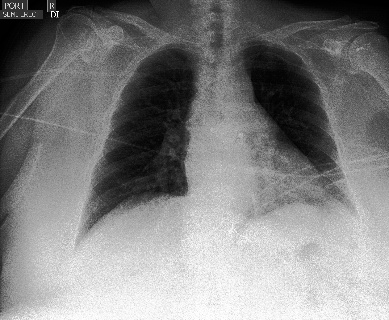

In [23]:
img = image.load_img(img_path)
display(img)

In [24]:
image.img_to_array(img).shape

(320, 389, 3)

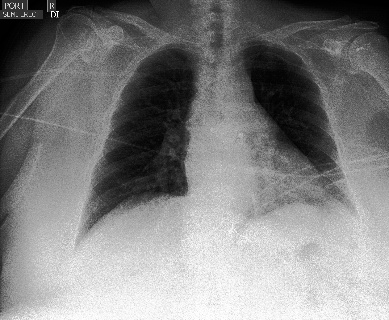

In [25]:
img = image.load_img(img_path, color_mode='grayscale')
img

In [26]:
image.img_to_array(img).shape

(320, 389, 1)

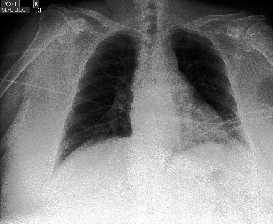

In [27]:
img_sm = image.load_img(img_path, color_mode='grayscale', target_size=(224, 273))
img_sm

In [28]:
image.img_to_array(img_sm).shape

(224, 273, 1)

### Okay, let's pipeline this image tensorization process and run it on all the images:

In [29]:
img_tensors = []
for img_path in train_info['Path'].values:
    img_tensors.append(image.img_to_array(image.load_img(img_path, color_mode='grayscale', target_size=(224, 273))))

In [30]:
X = np.array(img_tensors)

In [31]:
del img_tensors

In [32]:
# Multi-label target

y = train_info[['Atelectasis', 'Cardiomegaly', 'Edema', 'Pleural Effusion']].to_numpy()

In [33]:
print(X.shape)
print(y.shape)

(53528, 224, 273, 1)
(53528, 4)


### Perform stratified split to keep similar target distributions in each set
(Will go for a 70/15/15 split)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [35]:
# Check: Percentages in y should roughly match up w/ y_train and y_val

from collections import Counter
c = Counter()
for x in y:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.41),
 ((1, 0, 0, 0), 11.887),
 ((0, 0, 0, 1), 11.433),
 ((0, 0, 1, 0), 9.552),
 ((1, 0, 0, 1), 8.926),
 ((0, 0, 1, 1), 5.629),
 ((1, 0, 1, 0), 3.753),
 ((1, 0, 1, 1), 3.529),
 ((0, 1, 1, 0), 3.238),
 ((0, 1, 0, 0), 3.213),
 ((0, 1, 1, 1), 2.096),
 ((0, 1, 0, 1), 1.562),
 ((1, 1, 0, 0), 1.405),
 ((1, 1, 0, 1), 1.188),
 ((1, 1, 1, 1), 1.162),
 ((1, 1, 1, 0), 1.016)]

In [36]:
c = Counter()
for x in y_train:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_train.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.412),
 ((1, 0, 0, 0), 11.887),
 ((0, 0, 0, 1), 11.433),
 ((0, 0, 1, 0), 9.552),
 ((1, 0, 0, 1), 8.927),
 ((0, 0, 1, 1), 5.629),
 ((1, 0, 1, 0), 3.752),
 ((1, 0, 1, 1), 3.528),
 ((0, 1, 1, 0), 3.237),
 ((0, 1, 0, 0), 3.213),
 ((0, 1, 1, 1), 2.095),
 ((0, 1, 0, 1), 1.561),
 ((1, 1, 0, 0), 1.404),
 ((1, 1, 0, 1), 1.188),
 ((1, 1, 1, 1), 1.164),
 ((1, 1, 1, 0), 1.017)]

In [37]:
c = Counter()
for x in y_test:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_test.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.407),
 ((1, 0, 0, 0), 11.887),
 ((0, 0, 0, 1), 11.433),
 ((0, 0, 1, 0), 9.552),
 ((1, 0, 0, 1), 8.923),
 ((0, 0, 1, 1), 5.629),
 ((1, 0, 1, 0), 3.755),
 ((1, 0, 1, 1), 3.531),
 ((0, 1, 1, 0), 3.238),
 ((0, 1, 0, 0), 3.213),
 ((0, 1, 1, 1), 2.099),
 ((0, 1, 0, 1), 1.563),
 ((1, 1, 0, 0), 1.407),
 ((1, 1, 0, 1), 1.189),
 ((1, 1, 1, 1), 1.158),
 ((1, 1, 1, 0), 1.015)]

In [38]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [39]:
c = Counter()
for x in y_val:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_val.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.402),
 ((1, 0, 0, 0), 11.882),
 ((0, 0, 0, 1), 11.434),
 ((0, 0, 1, 0), 9.553),
 ((1, 0, 0, 1), 8.918),
 ((0, 0, 1, 1), 5.63),
 ((1, 0, 1, 0), 3.749),
 ((1, 0, 1, 1), 3.525),
 ((0, 1, 1, 0), 3.238),
 ((0, 1, 0, 0), 3.213),
 ((0, 1, 1, 1), 2.105),
 ((0, 1, 0, 1), 1.569),
 ((1, 1, 0, 0), 1.407),
 ((1, 1, 0, 1), 1.196),
 ((1, 1, 1, 1), 1.158),
 ((1, 1, 1, 0), 1.021)]

In [40]:
c = Counter()
for x in y_test:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_test.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.411),
 ((1, 0, 0, 0), 11.893),
 ((0, 0, 0, 1), 11.432),
 ((0, 0, 1, 0), 9.552),
 ((1, 0, 0, 1), 8.929),
 ((0, 0, 1, 1), 5.629),
 ((1, 0, 1, 0), 3.761),
 ((1, 0, 1, 1), 3.537),
 ((0, 1, 1, 0), 3.238),
 ((0, 1, 0, 0), 3.213),
 ((0, 1, 1, 1), 2.092),
 ((0, 1, 0, 1), 1.557),
 ((1, 1, 0, 0), 1.407),
 ((1, 1, 0, 1), 1.183),
 ((1, 1, 1, 1), 1.158),
 ((1, 1, 1, 0), 1.009)]

In [41]:
print('X_train: {},  y_train: {}'.format(X_train.shape, y_train.shape))
print('X_val: {},  y_val: {}'.format(X_val.shape, y_val.shape))
print('X_test: {},  y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (37469, 224, 273, 1),  y_train: (37469, 4)
X_val: (8029, 224, 273, 1),  y_val: (8029, 4)
X_test: (8030, 224, 273, 1),  y_test: (8030, 4)


#### Carve out "baby_train" and "baby_val" for fast-training model development & tweaking

In [43]:
_, X_baby, _, y_baby = train_test_split(X, y, test_size=0.023, stratify=y, random_state=42)
print('X_baby: {}, y_baby: {}'.format(X_baby.shape, y_baby.shape))

X_baby: (1232, 224, 273, 1), y_baby: (1232, 4)


In [44]:
X_baby_train, X_baby_val, y_baby_train, y_baby_val = train_test_split(X_baby, y_baby, test_size=0.2, stratify=y_baby, random_state=42)

In [45]:
c = Counter()
for x in y_baby:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_baby.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.438),
 ((1, 0, 0, 0), 11.851),
 ((0, 0, 0, 1), 11.445),
 ((0, 0, 1, 0), 9.578),
 ((1, 0, 0, 1), 8.929),
 ((0, 0, 1, 1), 5.601),
 ((1, 0, 1, 0), 3.734),
 ((1, 0, 1, 1), 3.49),
 ((0, 1, 1, 0), 3.247),
 ((0, 1, 0, 0), 3.247),
 ((0, 1, 1, 1), 2.11),
 ((0, 1, 0, 1), 1.542),
 ((1, 1, 0, 0), 1.38),
 ((1, 1, 0, 1), 1.218),
 ((1, 1, 1, 1), 1.136),
 ((1, 1, 1, 0), 1.055)]

In [46]:
c = Counter()
for x in y_baby_train:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_baby_train.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.457),
 ((1, 0, 0, 0), 11.878),
 ((0, 0, 0, 1), 11.472),
 ((0, 0, 1, 0), 9.543),
 ((1, 0, 0, 1), 8.934),
 ((0, 0, 1, 1), 5.584),
 ((1, 0, 1, 0), 3.756),
 ((1, 0, 1, 1), 3.452),
 ((0, 1, 1, 0), 3.249),
 ((0, 1, 0, 0), 3.249),
 ((0, 1, 1, 1), 2.132),
 ((0, 1, 0, 1), 1.523),
 ((1, 1, 0, 0), 1.421),
 ((1, 1, 0, 1), 1.218),
 ((1, 1, 1, 1), 1.117),
 ((1, 1, 1, 0), 1.015)]

In [47]:
c = Counter()
for x in y_baby_val:
    c[tuple(x)] += 1
    
for k in c.keys():
     c[k] = round(100*c[k]/y_baby_val.shape[0], 3)
    
c.most_common()

[((0, 0, 0, 0), 30.364),
 ((1, 0, 0, 0), 11.741),
 ((0, 0, 0, 1), 11.336),
 ((0, 0, 1, 0), 9.717),
 ((1, 0, 0, 1), 8.907),
 ((0, 0, 1, 1), 5.668),
 ((1, 0, 1, 0), 3.644),
 ((1, 0, 1, 1), 3.644),
 ((0, 1, 1, 0), 3.239),
 ((0, 1, 0, 0), 3.239),
 ((0, 1, 1, 1), 2.024),
 ((0, 1, 0, 1), 1.619),
 ((1, 1, 0, 0), 1.215),
 ((1, 1, 1, 1), 1.215),
 ((1, 1, 0, 1), 1.215),
 ((1, 1, 1, 0), 1.215)]

In [50]:
del X, y, X_baby, y_baby

In [91]:
np.save(open('data2/X_train.dat', 'wb'), X_train, allow_pickle=False)

In [92]:
np.save(open('data2/X_val.dat', 'wb'), X_val, allow_pickle=False)

In [93]:
np.save(open('data2/X_test.dat', 'wb'), X_test, allow_pickle=False)

In [94]:
np.save(open('data2/y_train.dat', 'wb'), y_train, allow_pickle=False)

In [95]:
np.save(open('data2/y_val.dat', 'wb'), y_val, allow_pickle=False)

In [96]:
np.save(open('data2/y_test.dat', 'wb'), y_test, allow_pickle=False)

In [51]:
np.save(open('data2/X_baby_train.dat', 'wb'), X_baby_train, allow_pickle=False)

In [52]:
np.save(open('data2/X_baby_val.dat', 'wb'), X_baby_val, allow_pickle=False)

In [53]:
np.save(open('data2/y_baby_train.dat', 'wb'), y_baby_train, allow_pickle=False)

In [54]:
np.save(open('data2/y_baby_val.dat', 'wb'), y_baby_val, allow_pickle=False)